# IDS Bayesian Interferometry

In [1]:
import pymc3 as pm
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
control = 0 # 0: sinthetic; 1: real
mycmap = 'seismic'
np.random.seed(53)

In [3]:
def show_fft_image(img_fft, shift = True, save = False , name = 'my_name.png'):
    
    img_fftabs = img_fft
    if type(img_fft[0,0]) == np.complex128:
        img_fftabs = np.abs(img_fft)
    
    if shift:
        img_fftabs = np.fft.fftshift(img_fftabs)
    plt.imshow(img_fftabs, cmap=mycmap)
    plt.grid('off')
    
    if save:
        plt.savefig(name, format= 'png')

In [4]:
def phi(U,a,b,c,e,f):
    try:
        u = U[:,0]
        v = U[:,1]
    except IndexError:
        u = U[0]
        v = U[1]
    return np.exp(2*np.pi**2*(a*v**2 + b*u**2 - c*u*v)/(4.*a*b-c**2) -2*np.pi*1j*(f*v+e*u))

def psi(x,y, a, b, c, e, f):
    invSigma = np.array([[-2.0*a,-c],[-c, -2.0*b]]).reshape(2,2)
#     print(invSigma)
    
    if not isinstance(x,np.ndarray):
        xx = np.array([x-e,y-f])
    else:
        xx = np.stack([x-e,y-f], axis = 1).T
    
    return np.exp(-0.5*xx.T.dot(invSigma).dot(xx))


## Creating artificial data

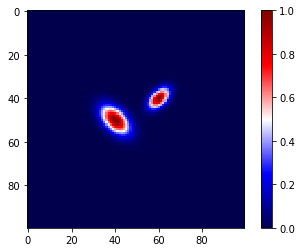

In [5]:
if control:
    path = '/home/lerko/Dataset_ALMA'
    fileName = 'Dataset_ALMA_11_07_17.mat'
    fullPath = path +'/' + fileName
    data = sio.loadmat(fullPath)
    
    img = data['Dataset']['name_3c286'][0,0]['size_128x128'][0,0]
    IMAGE_SIZE_X, IMAGE_SIZE_Y = img.shape
    print(data['Dataset'].dtype)
elif not control:
    x = np.arange(100)
    y = np.arange(100)
    
    s1 = np.array([20,10])
    s2 = np.array([20,10])
    s12 = np.array([10,-5])

    a = -0.5*s2/(s1*s2-s12**2)
    b = -0.5*s1/(s1*s2-s12**2)
    c = s12/(s1*s2-s12**2)
#     invSigma = np.array([[-2.*a,-c],[-c, -2.*b]])
#     print(np.linalg.inv(invSigma))

    e = np.array([50,40])
    f = np.array([40,60])
    numberOfBasis = e.shape[0]
    img = np.zeros((x.shape[0],y.shape[0]))

    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            for k in range(numberOfBasis):
                img[i,j] = img[i,j] + psi(x[i],y[j],a[k],b[k],c[k],e[k],f[k])
    IMAGE_SIZE_X, IMAGE_SIZE_Y = img.shape

plt.imshow(img, cmap=mycmap)
plt.colorbar()

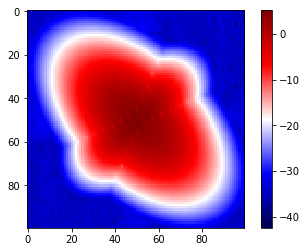

In [6]:
# Calculate the spectrum
img_fft= np.fft.fft2(img)
FTgshift = np.fft.fftshift(img_fft)

plt.imshow(np.log(np.abs(FTgshift)), cmap=mycmap)
plt.colorbar()

## Creating sampling mask


For creating the sampling mask, we have made a u,v representations based on the antennas disposition. This is because, if the antennas disposition is random, the measures are not completely random. The Measurements positions are defined by the interferometry physics.

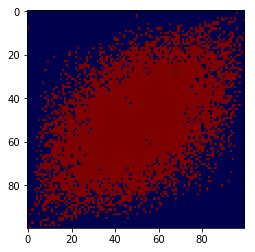

In [7]:
from masking import *

## Parameters
B_max = 1
antennas = 120
typeArray = 'URA'
sigma = B_max/6.0

lambda_phy=3*10**(-6); #(km)
H0=10; #(deg)
delta0=-30; #(deg)
Lat=34.05;  #(deg) Lat VLA

## Masking function returns the mask
mask = createSpectrumMasking(B_max,antennas,typeArray,sigma, lambda_phy, H0, delta0, Lat, N1 = IMAGE_SIZE_X, N2 = IMAGE_SIZE_Y)
show_fft_image(mask)

## Sampling

Variable `measurements` are the 2D representation for the measurements. `U` are the positions in the `u,v` spaces, i.e., `U[0] = u`, `U[1] = v`. Finally, `V` is the visibility function.

Percentage of measurements: 48.16


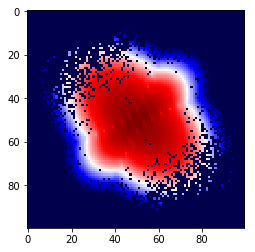

In [8]:
measurements,U,V = UVCreator(img_fft,mask)

measurements_abs = np.log(np.abs(measurements)+1e-12)
show_fft_image(measurements_abs)

p = 100*U.shape[0]/(measurements.shape[0]*measurements.shape[1]) 
print('Percentage of measurements: %s' % p)

## RBF Model
### Priors and Model

$$
V_{obs}(u,v) = \sum_{i=0}^{N_{b}-1}\alpha_i\phi_i(u,v)
$$

donde $\alpha_i \in \mathbb{R}$ y:

$$\phi_i(u,v) = \left[\begin{array}{c}
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \cos \big\lbrace C_x^iu+C_y^iv\big\rbrace \\
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \sin \big\lbrace C_x^iu+C_y^iv\big\rbrace
\end{array}\right]$$


$$
\phi_i(u,v) = 2 \pi \sigma^2 \exp \left(-2 \pi\left(j C_x^i u+jC_y^i v+\pi  \sigma^2\left(u^2+v^2\right)\right)\right) \vartheta _3\left(\pi  \left(2 j \pi  \sigma^2 u-C_x^i \right),e^{-2 \pi^2 \sigma^2}\right) \vartheta _3\left(\pi  \left(2 j \pi  \sigma^2 v-C_y^i\right),e^{-2 \pi^2 \sigma^2}\right)
$$


where:

$$
\vartheta_3 (q,z) = 1 + 2\sum_{n = 1}^{\infty} q^{n^2}\cos(2nz)
$$

In [9]:
import theano.tensor as tt

def tt_phi(U,a,b,c,e,f):
    u = U[:,0,np.newaxis]
    v = U[:,1,np.newaxis]
    
    A = tt.exp(2.0*np.pi**2*(tt.dot(a,tt.pow(v,2).T) + tt.dot(b,tt.pow(u,2).T) - tt.dot(c,(u*v).T))/(4.*a*b-tt.pow(c,2.0)))
    sinPart = tt.sin(-2*np.pi*(tt.dot(f,v.T)+tt.dot(e,u.T)))
    cosPart = tt.cos(-2*np.pi*(tt.dot(f,v.T)+tt.dot(e,u.T)))
    return A*cosPart, A*sinPart

def visibility_model(U,alpha,a,b,c,e,f, factor = None, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_Y):
    Uaux = U.astype(float)
    Uaux[:,0] = Uaux[:,0]/(IMAGE_SIZE_Y)
    Uaux[:,1] = Uaux[:,1]/(IMAGE_SIZE_X)
    realPart, imagPart = tt_phi(Uaux,a,b,c,e,f)
    
    return (alpha[:,np.newaxis]*realPart).sum(axis=0) , (alpha[:,np.newaxis]*imagPart).sum(axis=0)

In [10]:
def matrix_points(U,V_real, V_imag, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_X):
#     print(U.shape[0])
#     print(V_real.shape[0])
#     print(V_imag.shape[0])
    U = U.astype(int)
    out_real = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    out_imag = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    for i in range(U.shape[0]):
        out_real[U[i,0],U[i,1]] = V_real[i]
        out_imag[U[i,0],U[i,1]] = V_imag[i]
        
    return out_real, out_imag

[  2.00000000e+00  -1.59427581e+00   5.82611529e-01 ...,   2.04812639e-42
  -2.07895850e-42   9.76853263e-43]
(0.995653106034+0.00151184349659j)


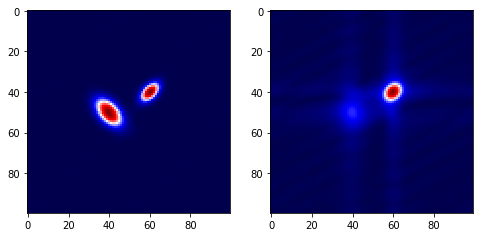

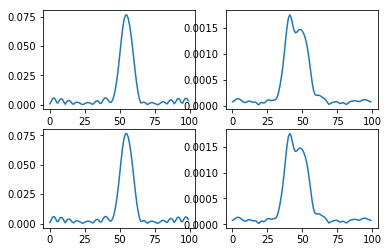

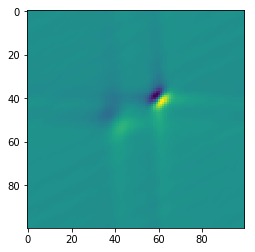

In [11]:
if control == 0:
    numberOfSamplings = U.shape[0]
    numberOfBasis = e.shape[0]

    init_s1 = s1
    init_s2 = s2
    init_s12 = s12
    init_alpha = np.array([1])
    init_e = e[:,np.newaxis]
    init_f = f[:,np.newaxis]
    init_a = a[:,np.newaxis]
    init_b = b[:,np.newaxis]
    init_c = c[:,np.newaxis]
    # print(init_C.shape)
    init_U = U.astype(int)

    u1 = np.arange((100))
    v1 = np.arange((100))

    myU = np.zeros((u1.shape[0]*v1.shape[0],2), dtype=np.int)
    k = 0
    for i in range(u1.shape[0]):
        for j in range(v1.shape[0]):
            myU[k,0] = u1[i]
            myU[k,1] = v1[j]
            k += 1
    
    PHI_Re, PHI_Im = visibility_model(init_U,init_alpha,init_a,init_b,init_c,init_e,init_f,
                                   IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y= IMAGE_SIZE_Y)
    
    print(PHI_Re.eval())
    Im_pix_real, Im_pix_imag = matrix_points(U,V[:,0], V[:,1])
    Im_pix_fft = Im_pix_real + 1j*Im_pix_imag
    Im_pix = np.fft.ifft2(Im_pix_fft)
    fig, ax = plt.subplots(1,2)
    fig.set_figheight(10)
    fig.set_figwidth(8)
    ax[0].imshow( np.abs(Im_pix) , cmap = mycmap)
    print(np.max(Im_pix))

    Im_ind_real, Im_ind_imag = matrix_points(init_U,PHI_Re.eval(), PHI_Im.eval(), IMAGE_SIZE_X=IMAGE_SIZE_X ,IMAGE_SIZE_Y=IMAGE_SIZE_Y)

    #Im_ind_real = ndimage.rotate(Im_ind_real, 90*2)
    #Im_ind_imag = ndimage.rotate(Im_ind_imag, 90*2)
    # Im_ind = np.log(np.sqrt(Im_ind_real*Im_ind_real+Im_ind_imag*Im_ind_imag) +1e-12)
    Im_ind_fft = Im_ind_real + 1j*Im_ind_imag
    # print(Im_ind_fft.shape)
    Im_ind = np.fft.ifft2(Im_ind_fft)
    #Im_ind = np.fft.fftshift(Im_ind)
    ax[1].imshow( np.abs(Im_ind) , cmap = mycmap)
    # print(np.max(Im_ind))

    fig, ax = plt.subplots(2,2)
    ax[0,0].plot(np.abs(Im_pix[:,50]))
    ax[0,1].plot(np.abs(Im_ind[:,50]))
    ax[1,0].plot(np.abs(Im_pix[:,50]))
    ax[1,1].plot(np.abs(Im_ind[:,50]))

    fig = plt.figure()
    plt.imshow(Im_ind.real)
    plt.imshow(Im_ind.imag)

In [12]:
#from scipy import optimize
numberOfSamplings = U.shape[0]
numberOfBasis = 6
rbf_model = pm.Model()

init_s = 20
s12_sd = 50

init_e = IMAGE_SIZE_Y/2
init_f = IMAGE_SIZE_X/2

beta_0 = 0.5
C_sd = IMAGE_SIZE_X/4
alpha_sd = 10


with rbf_model:
#     alpha_model = pm.Normal('alpha', mu=0, sd=alpha_sd, shape = numberOfBasis)
    alpha_s = pm.HalfNormal('alpha_s', sd=alpha_sd, shape = (numberOfBasis))
    alpha_model = pm.Normal('alpha', mu=0, sd=1./alpha_s, shape = (numberOfBasis))
                            
    s1_model = pm.Gamma('s1', alpha = beta_0*init_s+2, beta=beta_0, shape = (numberOfBasis,1))
    s2_model = pm.Gamma('s2', alpha = beta_0*init_s+2, beta=beta_0, shape = (numberOfBasis,1))
    s12_model = pm.Normal('s12', mu=0, sd=s12_sd, shape = (numberOfBasis,1))
    
    a_model = -0.5*s2_model/(s1_model*s2_model-tt.pow(s12_model,2.0))
    b_model = -0.5*s1_model/(s1_model*s2_model-tt.pow(s12_model,2.0))
    c_model = s12_model/(s1_model*s2_model-tt.pow(s12_model,2.0))
    
    e_model = pm.Normal('e', mu=init_e, sd=C_sd, shape = (numberOfBasis,1))
    f_model = pm.Normal('f', mu=init_f, sd=C_sd, shape = (numberOfBasis,1))

    sd_dist = pm.Normal.dist(0,0.1)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    sigma_model = tt.dot(chol, chol.T)
    
    PHI_Re, PHI_Im = visibility_model(U, alpha_model, a_model, b_model, c_model, e_model, f_model,
                                   IMAGE_SIZE_X=IMAGE_SIZE_X, IMAGE_SIZE_Y=IMAGE_SIZE_Y)
    V_model = tt.stack([PHI_Re, PHI_Im], axis = 1)

    V_obs = pm.MvNormal('V_obs', mu=V_model, cov=sigma_model, observed= V)
    
#     db = pm.backends.Text('test_log_normal')
#     n_samples = 1000
    
#     step = pm.Metropolis(vars=[alpha_model, Cx_model, Cy_model,l_model])
#     step = pm.Slice()
#     step = pm.NUTS()
#     trace = pm.sample(n_samples, step)
    estimation = pm.find_MAP()
    print(estimation)

Optimization terminated successfully.
         Current function value: 37342.854955
         Iterations: 446
         Function evaluations: 486
         Gradient evaluations: 486
{'alpha_s_log__': array([ 2.64915737,  2.64915737,  2.64915737, -4.33415446, -3.65471148,
        2.64915737]), 'alpha': array([  1.62012191e-04,   1.62013189e-04,   1.62008018e-04,
         1.07848517e+02,   5.46682657e+01,   1.62012216e-04]), 's1_log__': array([[ 3.17805502],
       [ 3.17805502],
       [ 3.17805502],
       [ 3.65099034],
       [ 3.00290783],
       [ 3.17805502]]), 's2_log__': array([[ 3.17805343],
       [ 3.17805343],
       [ 3.17805343],
       [ 3.64959316],
       [ 3.00861303],
       [ 3.17805343]]), 's12': array([[  3.78154288e-04],
       [  3.70847725e-04],
       [  3.87934600e-04],
       [  2.14021347e+01],
       [ -1.01694554e+01],
       [  3.63187783e-04]]), 'e': array([[ 50.00094612],
       [ 50.00095834],
       [ 50.00097994],
       [ 50.00712715],
       [ 39.9975

Asegurarme de que los parámetros reales son un máximo de la posterior.

In [13]:
e_test = estimation['e']
f_test = estimation['f']
s1_test = np.exp(estimation['s1_log__'])
s2_test = np.exp(estimation['s2_log__'])
print('s1:')
print(s1_test)
print('s2:')
print(s2_test)
s12_test = estimation['s12']

a_test = -0.5*s2_test/(s1_test*s2_test-s12_test**2)
b_test = -0.5*s1_test/(s1_test*s2_test-s12_test**2)
c_test = s12_test/(s1_test*s2_test-s12_test**2)

beta_test = estimation['alpha'][:,np.newaxis]*(4.*a_test*b_test-c_test**2)
print(beta_test)

Im_reconstructed = np.zeros((IMAGE_SIZE_X,IMAGE_SIZE_Y))
for k in range(numberOfBasis):
    for i in range(IMAGE_SIZE_X):
        for j in range(IMAGE_SIZE_Y):
            Im_reconstructed[i,j] = Im_reconstructed[i,j] + beta_test[k]*psi(x[i],y[j],a_test[k],b_test[k],c_test[k],e_test[k],f_test[k])

s1:
[[ 24.00002845]
 [ 24.00002857]
 [ 24.00002865]
 [ 38.51278806]
 [ 20.14402722]
 [ 24.00002846]]
s2:
[[ 23.99999038]
 [ 23.99999031]
 [ 23.99999041]
 [ 38.45901604]
 [ 20.25928139]
 [ 23.99999039]]
[[  2.81270944e-07]
 [  2.81272677e-07]
 [  2.81263696e-07]
 [  1.05412171e-01]
 [  1.79425115e-01]
 [  2.81270987e-07]]


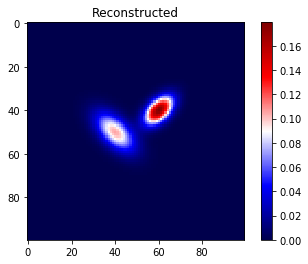

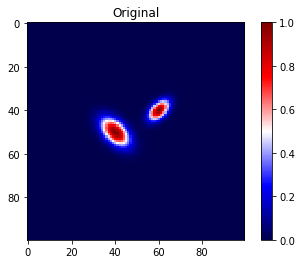

In [14]:
plt.figure()
plt.imshow(Im_reconstructed, cmap=mycmap)
plt.colorbar()
plt.grid('off')
plt.title('Reconstructed')

plt.figure()
plt.imshow(img, cmap=mycmap)
plt.colorbar()
plt.grid('off')
plt.title('Original')

In [15]:
print(np.sum((Im_reconstructed*np.max(img)/np.max(Im_reconstructed) -  img)**2) )

15.726472842


In [16]:
print(np.sum((np.max(img)*np.abs(Im_pix)/np.max(np.abs(Im_pix)) -  img)**2) )

0.0980622875031
